<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Feature Engineering </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. Vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados;
- Calculando estatísticas sobre o conjunto de dados;
- Visualização univariada;
- Visualizando multivariada;
- Pré-processamento. 

Outros pontos que vou abordar em relação ao entendimento dos dados: 
- Variação por estação e dia da semana;
- O efeito da Páscoa;
- Zoom no pico de fim de ano;
- Crescimento anual.

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q holidays
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import multiprocessing
import holidays

In [107]:
import pandas                 as pd
import numpy                  as np
import matplotlib.pyplot      as plt 
import seaborn                as sns
import joblib                 as jb
import xgboost                as xgb
import lightgbm               as lgb
import scipy.stats            as stats
import statsmodels.api        as sm
import dateutil.easter        as easter
import plotly.express         as px

In [4]:
from sklearn.model_selection  import TimeSeriesSplit
from sklearn.preprocessing    import StandardScaler, MinMaxScaler, power_transform
from sklearn.preprocessing    import PowerTransformer, RobustScaler, normalize
from sklearn.preprocessing    import MaxAbsScaler, QuantileTransformer, LabelEncoder

In [5]:
from datetime                 import datetime
from pylab                    import rcParams
from matplotlib.ticker        import MaxNLocator, FormatStrFormatter, PercentFormatter
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from matplotlib.axes._axes    import _log as matplotlib_axes_logger
from scipy.stats              import skew, norm
from datetime                 import timedelta
from sklearn.pipeline         import make_pipeline

In [6]:
from sklearn.ensemble         import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble         import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model     import LinearRegression, Ridge #, Lasso, ElasticNet,SGDRegressor
from catboost                 import CatBoostRegressor,Pool

In [7]:
#from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor
#from yellowbrick.regressor   import ResidualsPlot

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [8]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
            
        pd.options.mode.chained_assignment = None 

        #from warnings import simplefilter




        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_, smape_base_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
            
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [9]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

## 1.4. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [10]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/09 - Setembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'num_sold'

utility.create_fold(path)

In [11]:
df1_train     = pd.read_csv(path + 'Data/train.csv')
df1_test      = pd.read_csv(path + 'Data/test.csv')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df1_train.shape, df1_test.shape, df_submission.shape

((70128, 6), (17520, 5), (17520, 2))

In [12]:
df1_train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [13]:
df1_test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Engenharia de recursos </h1>    
</div>

Neste parte do processo de modelagem, vamos considerar os seguintes pontos para criarmos novas variáveis (features):    
- país, loja, produto;
- dias úteis;
- páscoa;
- variações sazonais por produto. <p><br>

Como baseline vamos fazer um modelo com poucas variáveis transformadas em relação ao tempo, no próximo notebook(Feature engineering) vamos criar novas variáveis, com base nos insights desta EDA, abaixo foi criado uma função para gerar as nova variáveis. <br>

## 2.1. Feature 01

In [14]:
seed = 12359

In [15]:
def feature_time(df_):         

    df_['fe_day_of_week']    = df_['date'].dt.dayofweek.astype(int)
    df_['fe_day_of_year']    = df_['date'].dt.dayofyear.astype(int) 
    df_['fe_quarter']        = df_['date'].dt.quarter.astype(int)
    df_['fe_month']          = df_['date'].dt.month.astype(int)
    df_['fe_year']           = df_['date'].dt.year.astype(int)        
    df_['fe_day_of_month']   = df_['date'].dt.day.astype(int)
    df_['fe_week_of_year']   = df_['date'].dt.isocalendar().week.astype(int)
    df_['fe_week_of_month']  = (df_['fe_week_of_year'].values//4.35).astype(int)        
    df_['fe_is_month_start'] = df_['date'].dt.is_month_start.astype(int)
    df_['fe_is_month_end']   = df_['date'].dt.is_month_end.astype(int) 

    '''


    

    
    #df_['fe_days_till_next_holiday'] = df_.apply(lambda x: days_till_next_holiday(x['country'], 
    #                                                                              x['date']), axis=1)
    
    
    

    


   

    
    

    

    '''
    
    #df_.set_index('date', inplace=True, drop=True)

    return df_

In [16]:
def feature_day_week(df_): 
    
    # Marca o dia da semana
    df_['fe_is_mon']     = np.where(df_['date'].dt.dayofweek.astype(int) == 1, 1, 0)
    df_['fe_is_tue']     = np.where(df_['date'].dt.dayofweek.astype(int) == 2, 1, 0)
    df_['fe_is_wed']     = np.where(df_['date'].dt.dayofweek.astype(int) == 3, 1, 0)
    df_['fe_is_thu']     = np.where(df_['date'].dt.dayofweek.astype(int) == 4, 1, 0)
    df_['fe_is_fri']     = np.where(df_['date'].dt.dayofweek.astype(int) == 5, 1, 0)
    df_['fe_is_sat']     = np.where(df_['date'].dt.dayofweek.astype(int) == 6, 1, 0)  
    df_['fe_is_fri_sat'] = (df_['date'].dt.weekday >= 5).astype(int)  
    
    return df_

In [17]:
def create_feature_dammy(df_, feature_dammy_):            
    for col in feature_dammy_:        
        for col_ in df_[col].unique()[:-1]:
            df_['fe_dm_' + col_] = (df_[col]==col_).astype(int)  
        df_.drop(col, axis=1, inplace=True)
    
    return df_

In [18]:
def feature_gdp(df_):
    
    df_gdp = pd.read_csv(path+'Data/GDP_data_2017_to_2021.csv')
    df_    = df_.merge(df_gdp, left_on=['country', 'fe_year'], right_on=['country', 'year'],how='left')
    df_.drop('year', axis=1, inplace=True)
    
    return df_

In [19]:
def feature_ajustment_date(df_): 
    
    # passo 1
    df_.loc[(df_.date.dt.is_leap_year) & (df_.fe_day_of_year >= 60),'fe_day_of_year'] -= 1
    
    # passo 2 
    df_["fe_day_of_year"] = df_.apply(lambda x: x["fe_day_of_year"]-1 \
                                      if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] \
                                      < pd.Timestamp("2021-01-01"))  else x["fe_day_of_year"], axis=1)

    # passo 3 
    df_['fe_sp_day'] = (df_['date'].dt.month*100 + df_['date'].dt.day).isin([101,1228,1229,1230,1231]).astype(int)    
    df_ = pd.get_dummies(df_, columns = ['fe_day_of_week'], drop_first=True)
        
    # Páscoa 
    easter_date = df_.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df_['fe_easter'] = 0 
    df_['fe_easter'] = (df_.date - easter_date).dt.days.eq(1).astype(int)
    
    #for day in list(range(1, 5)):
    #    df_[f'fe_easter_{day}'] = (df_.date - easter_date).dt.days.eq(day)
                      
    return df_   

In [119]:
def feature_fourier(df_):
    
    # Variações sazonais (série Fourier)
    # Os três produtos têm padrões sazonais diferentes   
    # k=1 -> 2 years, k=2 -> 1 year, k=4 -> 6 months
    seasonality_list = [1, 2, 3, 4] # 6,  12, 52, 104
    dayofyear        = df_.date.dt.dayofyear
        
    for k in seasonality_list:
        df_[f'fe_sin_{k}'] = np.sin(dayofyear / 365 * 2 * np.pi * k)
        df_[f'fe_cos_{k}'] = np.cos(dayofyear / 365 * 2 * np.pi * k)  
        for i, p in enumerate(df_['product'].unique()): 
            product = p            
            df_[f'fe_four_sin_{k}_{product}']  = df_[f'fe_sin_{k}'] * (df_['product']==p).astype(int)
            df_[f'fe_four_cos_{k}_{product}']  = df_[f'fe_cos_{k}'] * (df_['product']==p).astype(int)
        df_.drop([f'fe_sin_{k}'], axis=1, inplace=True)
        df_.drop([f'fe_cos_{k}'], axis=1, inplace=True)
                
    return df_

In [120]:
def feature_cci(df_):

    country_location = {'FRA': 'France','POL': 'Poland','ESP': 'Spain','BEL': 'Belgium',
                        'ITA': 'Italy','DEU': 'Germany', 'OECD': 'Other'}
        
    df_cci = pd.read_csv(path + 'Data/consumer_confidence_index_cci.csv')
    
    df_cci['country'] = df_cci['Location'].map(country_location)
    df_cci['year']    = df_cci['Time'].str.split('-', expand = True)[0].astype(int)
    df_cci['month']   = df_cci['Time'].str.split('-', expand = True)[1].astype(int)

    #df_  = df1_train.copy()
    df_['year']  = df_['date'].dt.year
    df_['month'] = df_['date'].dt.month

    df_ = df_.merge(df_cci[['country', 'year', 'month', 'cci_value']], 
                    how      = 'left', 
                    left_on  = ['country', 'year', 'month'], 
                    right_on = ['country', 'year', 'month'])

    df_.drop(['year', 'month'], axis=1, inplace=True)
    df_.head()
    
    return df_ 

In [121]:
def feature_season(df_):

    years     = df_['date'].dt.year.unique().tolist() 
    years_min = [np.min(years)-1]
    years_max = [np.max(years)+1]
    years     = years_min + years + years_max

    df_['fe_season'] = np.nan

    for year in years: 
        season = [('fe_winter', str(year) + '-04-21', str(year) + '-06-20'),
                  ('fe_spring', str(year) + '-06-21', str(year) + '-09-20'),
                  ('fe_summer', str(year) + '-09-21', str(year) + '-12-20'),
                  ('fe_autumn', str(year) + '-12-21', str(year+1) + '-04-20')]
        for s in season: 
            df_['fe_season'][(df_['date']>=s[1]) & (df_['date']<=s[2])] = s[0]

    df_ =  create_feature_dammy(df_, ['fe_season'])

    return df_

In [122]:
def end_year(df_):

    df_dec  = pd.DataFrame({f"fe_dec_{d}": (df_.date.dt.month==12) & (df_.date.dt.day==d)
                           for d in range(26, 32)}).astype(int)

    df_jan  = pd.DataFrame({f"fe_jan_{d}": (df_.date.dt.month==1) & (df_.date.dt.day==d)
                           for d in range(1, 5)}).astype(int)

    df_may1 = pd.DataFrame({f"fe_may_{d}": (df_.date.dt.month==5) & (df_.date.dt.day==d)
                           for d in range(1, 10)}).astype(int)

    df_may2 = pd.DataFrame({f"fe_may_{d}": (df_.date.dt.month==5) & (df_.date.dt.day==d)
                            for d in range(19, 26)}).astype(int)

    df_jun  = pd.DataFrame({f"fe_june_{d}": (df_.date.dt.month==6) & (df_.date.dt.day==d)
                            for d in range(8, 14)}).astype(int)    

    df_ = pd.concat([df_, df_dec, df_jan, df_jun], axis=1)    # df_may1, df_may1

    df_['fe_week_after_easter']='fe_week_after_easter_99'

    for y in df_['date'].dt.year.unique():     
        day_easter_i = pd.Timestamp(easter.easter(y))
        day_easter_f = pd.Timestamp(easter.easter(y)+timedelta(6))
        filtro = (df_['date']>=day_easter_i)  & (df_['date']<=day_easter_f)
        for i, d in enumerate(df_[filtro].date.unique()):
            df_['fe_week_after_easter'][df_['date']==d] = f'fe_week_after_easter_{i+1}' 

    df_ =  create_feature_dammy(df_, ['fe_week_after_easter']) 

    return df_

In [123]:
def feature_map_holydays(df_, years_list_=[], countries_=[]):

    countries_  = ['BE', 'FR', 'DE', 'IT', 'PL', 'ES' ]   
    years_list_ = [2017, 2018, 2019, 2020, 2021] 

    df_ = df1_train.copy()


    countries = [('Belgium', 'BE'), ('France', 'FR'), 
                 ('Germany', 'DE'), ('Italy', 'IT'), 
                 ('Poland', 'PL'), ('Spain', 'ES')]

    df_['fe_holiday']      = np.nan
    df_['fe_is_holiday']   = np.nan
    #df_['fe_holiday_name'] = np.nan

    for country in countries:
        dic_holidays = holidays.CountryHoliday(country[0], years=years_list_)
        df_['fe_holiday'][df_['country']==country[0]]    = df_['date'].map(dic_holidays)
        df_['fe_is_holiday'][df_['country']==country[0]] = np.where(df_['fe_holiday'].notnull(), 1, 0)
        df_['fe_holiday'][df_['country']==country[0]]    = df_['fe_holiday'].fillna('Not Holiday')

    df_['fe_is_holiday'] = df_['fe_is_holiday'].astype(int)
    df_.drop(['fe_holiday'], axis=1, inplace=True)

    
    return df_

In [124]:
def create_feature_engineering(df_, target_, feature_dammy_=[]):

    for df in [df_]:
        df_['date'] = df_['date'].astype(np.Datetime64)
        df_.loc[df_['product']=='Kaggle Advanced Techniques','product']       = 'A'
        df_.loc[df_['product']=='Kaggle Getting Started','product']           = 'B'
        df_.loc[df_['product']=='Kaggle Recipe Book','product']               = 'C'
        df_.loc[df_['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'    
                
        df_ = feature_cci(df_)
        df_ = feature_time(df_)
        df_ = feature_day_week(df_)
        df_ = feature_gdp(df_)
        df_ = feature_ajustment_date(df_)
        df_ = feature_fourier(df_)
        
        df_ = feature_season(df_)
        df_ = end_year(df_)
        
        # --------------------------------------------
        # Feriado 
        # --------------------------------------------
        countries  = ['BE', 'FR', 'DE', 'IT', 'PL', 'ES' ]   
        years_list = [2017, 2018, 2019, 2020, 2021] 

        #df_ = feature_map_holydays(df_, years_list_=[], countries_=[])

            
    df_ = create_feature_dammy(df_, feature_dammy_)
       
    df_['fe_dammy_sum'] = df_.filter(regex=r'fe_dm').sum(axis=1)
    
    # Remover recursos constantes
    cols_four = df_.filter(regex=r'fe_four').columns.to_list()
    
    feature_const = DropConstantFeatures(tol=0.95).fit(df_)  # [cols_four]
    feature_drop  = feature_const.features_to_drop_ 
    
    #print(feature_drop)
    
    feature_corr  = ['fe_quarter', 'fe_week_of_month', 'fe_week_of_year', 
                     'fe_day_of_week_1','fe_day_of_week_2','fe_day_of_week_3','fe_day_of_week_4',
                     'fe_day_of_week_5','fe_day_of_week_6',                      
                     
                     'fe_is_month_start', 'fe_is_month_end', 'fe_sp_day', 'fe_easter', 'fe_dec_26', 
                     'fe_dec_27', 'fe_dec_28', 'fe_dec_29', 'fe_dec_30', 'fe_dec_31', 'fe_jan_1', 
                     'fe_jan_2', 'fe_jan_3', 'fe_jan_4', 'fe_june_8', 'fe_june_9', 'fe_june_10', 
                     'fe_june_11', 'fe_june_12', 'fe_june_13', 'fe_dm_fe_week_after_easter_99', 
                     'fe_dm_fe_week_after_easter_1', 'fe_dm_fe_week_after_easter_2', 'fe_dm_fe_week_after_easter_3', 
                     'fe_dm_fe_week_after_easter_4', 'fe_dm_fe_week_after_easter_5', 'fe_dm_fe_week_after_easter_6'
                    ]
    
    feature_drop  = feature_corr #+ feature_drop      
    df_.drop(feature_drop, axis=1, inplace=True)
    
    if target_ is not None:
        y = df_[target]
        df_.drop(target_, axis=1, inplace=True)
        df_[target] = y

    df_.set_index('date', inplace=True, drop=False)
    df_.drop('date', axis=1, inplace=True)
    
    return df_

In [125]:
%%time 

country  = 'Poland' 
store    = 'KaggleMart'
product  = 'Kaggle Advanced Techniques'

df2_train = df1_train.drop('row_id', axis=1).copy()
df2_test  = df1_test.drop('row_id', axis=1).copy()

feature   = ['country','product', 'store']
df2_train = create_feature_engineering(df2_train, target, feature)
df2_test  = create_feature_engineering(df2_test, None, feature)

display(df2_train.shape, df2_test.shape, df2_train.head())

(70128, 59)

(17520, 58)

,cci_value,fe_day_of_year,fe_month,fe_year,fe_day_of_month,fe_is_mon,fe_is_tue,fe_is_wed,fe_is_thu,fe_is_fri,fe_is_sat,fe_is_fri_sat,GDP,fe_four_sin_1_A,fe_four_cos_1_A,fe_four_sin_1_B,fe_four_cos_1_B,fe_four_sin_1_C,fe_four_cos_1_C,fe_four_sin_1_D,fe_four_cos_1_D,fe_four_sin_2_A,fe_four_cos_2_A,fe_four_sin_2_B,fe_four_cos_2_B,fe_four_sin_2_C,fe_four_cos_2_C,fe_four_sin_2_D,fe_four_cos_2_D,fe_four_sin_3_A,fe_four_cos_3_A,fe_four_sin_3_B,fe_four_cos_3_B,fe_four_sin_3_C,fe_four_cos_3_C,fe_four_sin_3_D,fe_four_cos_3_D,fe_four_sin_4_A,fe_four_cos_4_A,fe_four_sin_4_B,fe_four_cos_4_B,fe_four_sin_4_C,fe_four_cos_4_C,fe_four_sin_4_D,fe_four_cos_4_D,fe_dm_fe_autumn,fe_dm_fe_winter,fe_dm_fe_spring,fe_dm_Belgium,fe_dm_France,fe_dm_Germany,fe_dm_Italy,fe_dm_Poland,fe_dm_A,fe_dm_B,fe_dm_C,fe_dm_KaggleMart,fe_dammy_sum,num_sold
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,1,0,0,1,5,663
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,0,1,0,1,5,615
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.05162,0.998667,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.068802,0.99763,0.000000,0.00000,1,0,0,1,0,0,0,0,0,0,1,1,5,480
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.05162,0.998667,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.068802,0.99763,1,0,0,1,0,0,0,0,0,0,0,1,4,710
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,1,0,0,0,4,240


CPU times: total: 4.48 s
Wall time: 4.53 s


### 2.1.1. Correlação

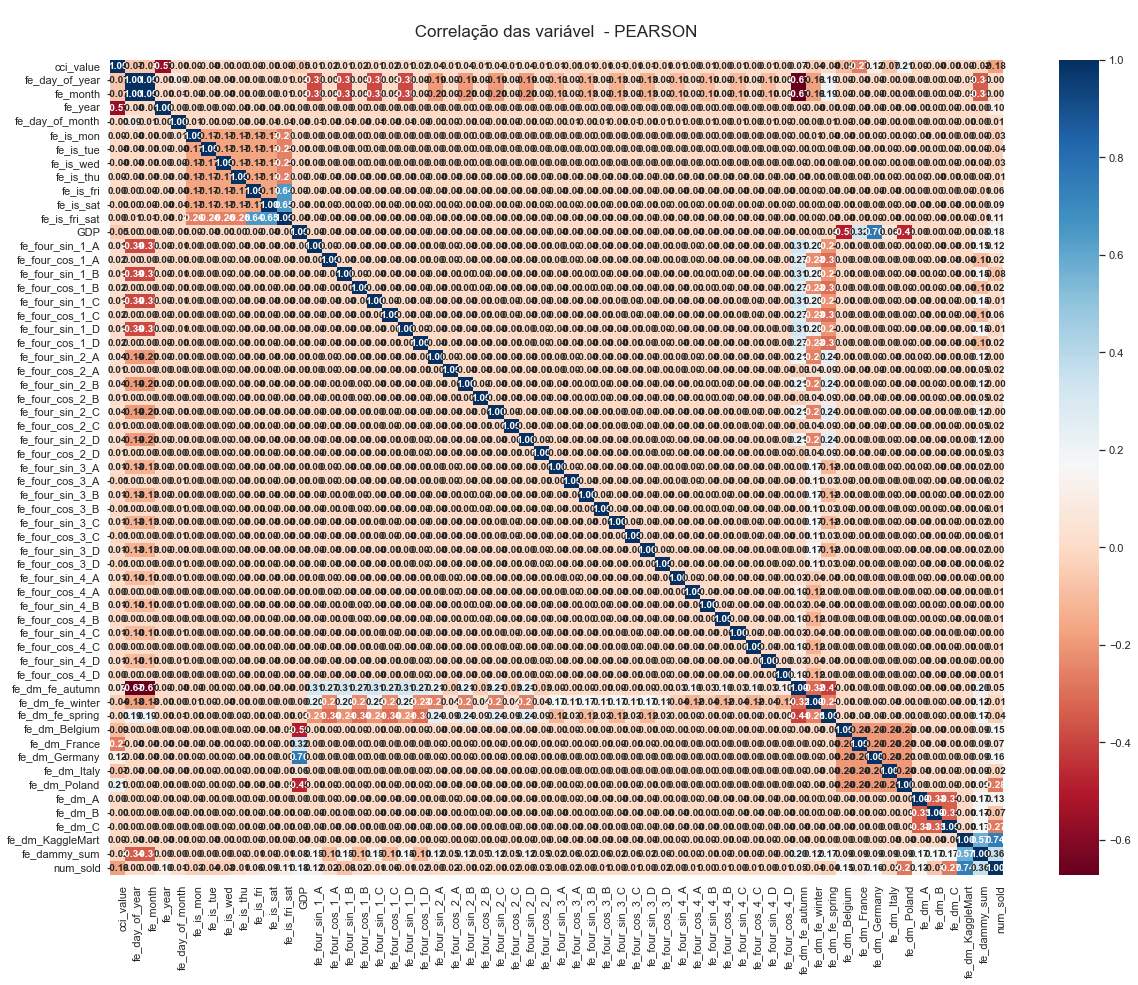

{'fe_month'}

In [126]:
plt.figure(figsize=(20,15))

utility.graf_feature_corr(df2_train.copy(),
                          annot_      = True,
                          threshold_  = 0.8,
                          print_var_  = False,
                          print_graf_ = True,
                          mask_       = False)

### 2.1.1. Treine o modelo

In [127]:
def fit_model_feature_engineering(model_, X_tr_, y_tr, X_vl_, y_vl_, target_=target, 
                                  scaler_=None, feature_scaler_=None):
    
    cols       = X_tr_.columns
    X_train_sc = X_tr_
    X_valid_sc = X_vl_
    
    if scaler_ is not None:         
        if feature_scaler_ is not None: 
            scaler_.fit(X_train_sc[feature_scaler_])
            X_train_sc[feature_scaler_] = scaler_.transform(X_train_sc[feature_scaler_])
            X_valid_sc[feature_scaler_] = scaler_.transform(X_vl_[feature_scaler_])

    X_train_sc.index   = X_tr_.index
    X_valid_sc.index   = X_vl_.index
    
    model_.fit(X_train_sc, np.log(y_tr))
    #model_.fit(X_train_sc, y_tr)
    
    name_pred = target_+'_pred'
    
    X_valid_sc[name_pred] = np.exp(model_.predict(X_valid_sc)).astype(int)
    #X_valid_sc[name_pred] = model_.predict(X_valid_sc).astype(int)
    X_valid_sc[target_]   = y_vl_
        
    rmse, mae, mse, mape, r_squared, smape = \
          utility.evaluation(y_vl_, X_valid_sc.num_sold_pred, smape_base_=200) 
    
    msg = '=> RMSE: {:2.5F} - MAE: {:2.5F} - SMAPE: {:2.5F}'
    print(msg.format(rmse, mae, smape))
    print()
    
    plt.figure(figsize=(20, 6))
    plt.plot(X_valid_sc.index, X_valid_sc.num_sold, label='Real')
    plt.plot(X_valid_sc.index, X_valid_sc.num_sold_pred, label='Prediction')

    plt.legend()
    plt.title('Previsões e num_sold por cinco anos')
    plt.show()
        
    return model_, scaler_

=> RMSE: 22.94698 - MAE: 13.78508 - SMAPE: 6.20228



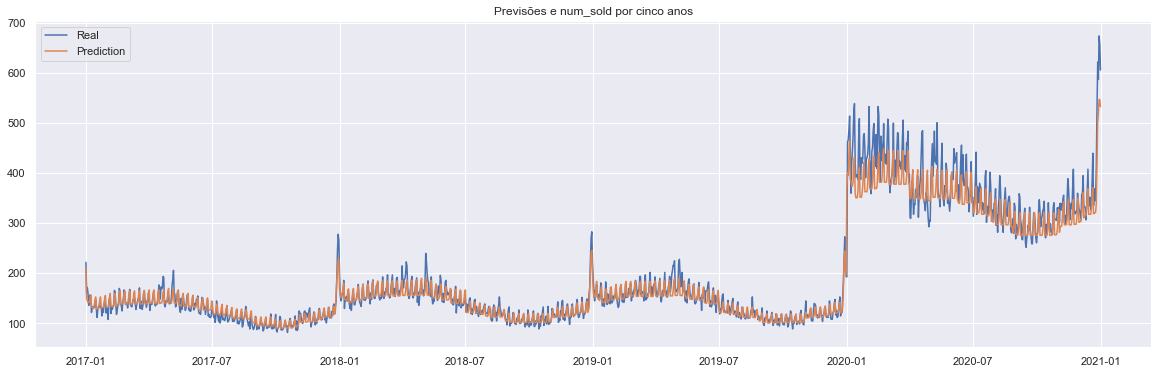

CPU times: total: 8.48 s
Wall time: 6.5 s


In [128]:
%%time 

filtro   = (df2_train['fe_dm_Poland']==1) & \
           (df2_train['fe_dm_A']==1)     & \
           (df2_train['fe_dm_KaggleMart']==1) 

filtro2  = (df2_test['fe_dm_Poland']==1) & \
           (df2_test['fe_dm_A']==1)     & \
           (df2_test['fe_dm_KaggleMart']==1) 

df_valid = df2_train[filtro].copy()
#df_valid = pd.concat([df_valid, df2_test[filtro2] ])

X_train = df2_train.drop([target], axis=1).copy()
y_train = df2_train[target]
X_valid = df_valid.drop([target], axis=1).copy()
y_valid = df_valid[target]

feature_scaler = ['fe_day_of_year', 'fe_year', 'cci_value',
                  'fe_day_of_month', 'fe_dammy_sum', 'fe_sum_all'] 

model = xgb.XGBRegressor(**params_xgb)
#model = Ridge()
#model  = HistGradientBoostingRegressor(random_state=seed)
model_, scaler_ = \
    fit_model_feature_engineering(model_          = model , 
                                  X_tr_           = X_train, 
                                  y_tr            = y_train, 
                                  X_vl_           = X_valid, 
                                  y_vl_           = y_valid, 
                                  target_         = target, 
                                  scaler_         = None, 
                                  feature_scaler_ = feature_scaler)

# => RMSE: 109.14371 - MAE: 100.87201- SMAPE: 48.81163 
# => RMSE: 101.76855 - MAE: 69.94935 - SMAPE: 32.87798 com transformação de log
# => RMSE: 101.49361 - MAE: 69.70089 - SMAPE: 32.71591 com acrescimo da feature dia da semana
# => RMSE: 53.08132  - MAE: 36.71937 - SMAPE: 16.38144 com acrescimo da feautre sum de todas as variáveis
# => RMSE: 52.96299 - MAE: 36.66051  - SMAPE: 16.36410 com acrescimo da feature gdp com remoção de variáveis 
# => RMSE: 52.95086 - MAE: 36.65229 - SMAPE: 16.36007 com ajuste de data passo 1 com remoção de variáveis
# => RMSE: 52.92516 - MAE: 36.63860 - SMAPE: 16.35500 com ajuste de data passo 2 com remoção de variáveis
# => RMSE: 52.92960 - MAE: 36.63792 - SMAPE: 16.35386 com ajuste de data passo 3 com remoção de variáveis
# => RMSE: 54.25364 - MAE: 36.88706 - SMAPE: 16.32496 inclusão da variável páscoa e retorno das var excluídas

# => RMSE: 57.59983 - MAE: 33.98700 - SMAPE: 13.35260 inclusão das variáveis de tomada de fourier

# => RMSE: 7.29373 - MAE: 5.40657 - SMAPE: 3.00997 
# => RMSE: 8.25160 - MAE: 5.83984 - SMAPE: 3.18010 
# => RMSE: 7.47265 - MAE: 5.42163 - SMAPE: 2.98146 


# => RMSE: 57.58516 - MAE: 33.99589 - SMAPE: 13.36059

# => RMSE: 6.28733 - MAE: 4.87064 - SMAPE: 3.07405 sem scaler
# => RMSE: 6.25020 - MAE: 4.82409 - SMAPE: 3.01762 com scaler

# => RMSE: 3.18847 - MAE: 0.82615 - SMAPE: 0.44566 sem scaler 
# => RMSE: 3.17922 - MAE: 0.83162 - SMAPE: 0.44835 com scaler rigder


# => RMSE: 55.76110 - MAE: 32.85695 - SMAPE: 12.89226

In [129]:
X_train.head()

,cci_value,fe_day_of_year,fe_month,fe_year,fe_day_of_month,fe_is_mon,fe_is_tue,fe_is_wed,fe_is_thu,fe_is_fri,fe_is_sat,fe_is_fri_sat,GDP,fe_four_sin_1_A,fe_four_cos_1_A,fe_four_sin_1_B,fe_four_cos_1_B,fe_four_sin_1_C,fe_four_cos_1_C,fe_four_sin_1_D,fe_four_cos_1_D,fe_four_sin_2_A,fe_four_cos_2_A,fe_four_sin_2_B,fe_four_cos_2_B,fe_four_sin_2_C,fe_four_cos_2_C,fe_four_sin_2_D,fe_four_cos_2_D,fe_four_sin_3_A,fe_four_cos_3_A,fe_four_sin_3_B,fe_four_cos_3_B,fe_four_sin_3_C,fe_four_cos_3_C,fe_four_sin_3_D,fe_four_cos_3_D,fe_four_sin_4_A,fe_four_cos_4_A,fe_four_sin_4_B,fe_four_cos_4_B,fe_four_sin_4_C,fe_four_cos_4_C,fe_four_sin_4_D,fe_four_cos_4_D,fe_dm_fe_autumn,fe_dm_fe_winter,fe_dm_fe_spring,fe_dm_Belgium,fe_dm_France,fe_dm_Germany,fe_dm_Italy,fe_dm_Poland,fe_dm_A,fe_dm_B,fe_dm_C,fe_dm_KaggleMart,fe_dammy_sum
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,1,0,0,1,5
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,0,1,0,1,5
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.05162,0.998667,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.068802,0.99763,0.000000,0.00000,1,0,0,1,0,0,0,0,0,0,1,1,5
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.05162,0.998667,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.068802,0.99763,1,0,0,1,0,0,0,0,0,0,0,1,4
2017-01-01,100.6824,1,1,2017,1,0,0,0,0,0,1,1,0.5015,0.017213,0.999852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034422,0.999407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05162,0.998667,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.068802,0.99763,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1,0,0,1,0,0,0,0,1,0,0,0,4


In [130]:
#CCI: https://www.kaggle.com/code/cv13j0/tps-sep22-baseline-gradient-boosted-trees#7.-Feature-Engineering

In [ ]:
def create_features_(df, target):

    
    
    df['fe_is_wknd']        = df['date'].dt.weekday // 4
    df['fe_is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['fe_is_month_end']   = df['date'].dt.is_month_end.astype(int)
    
    
    
    '''
    df['lag_6_hrs']   = df[target].shift(6)
    df['lag_12_hrs']  = df[target].shift(12)
    df['lag_24_hrs']  = df[target].shift(24)
    
    df['mean_6_hrs']  = df[target].rolling(window = 6).mean()
    df['mean_12_hrs'] = df[target].rolling(window = 12).mean()
    df['mean_24_hrs'] = df[target].rolling(window = 24).mean()
    df['std_6_hrs']   = df[target].rolling(window = 6).std()
    df['std_12_hrs']  = df[target].rolling(window = 12).std()
    df['std_24_hrs']  = df[target].rolling(window = 24).std()
    df['max_6_hrs']   = df[target].rolling(window = 6).max()
    df['max_12_hrs']  = df[target].rolling(window = 12).max()
    df['max_24_hrs']  = df[target].rolling(window = 24).max()
    df['min_6_hrs']   = df[target].rolling(window = 6).min()
    df['min_12_hrs']  = df[target].rolling(window = 12).min()
    df['min_24_hrs']  = df[target].rolling(window = 24).min()
    '''
        
    # generating some new features from aggregation of sales within different time frames
    # https://www.kaggle.com/hikmetsezen/base-model-with-lightgbm-on-demand-forecasting
    shift_values = [0, 0, 0, 0, 0, 0, 12, 12]
    feat_list    = ['day_of_week', 'week_of_month', 'week_of_year', 'month', 
                    'quarter', 'is_wknd', 'day_of_week', 'week_of_month']
    

    #for time_item, shift_val in zip(feat_list, shift_values):
        #print(shift_val)
        # 'country','store','product'
        
        #grouped_df = df.groupby(['store', 'item', time_item])['sales'].expanding().mean().shift(shift_val).bfill().reset_index()
        #grouped_df.columns = ['store', 'item', time_item, 'date', time_item + f'_ex_avg_sale{str(shift_val)}']
        #grouped_df = grouped_df.sort_values(by=['item', 'store', 'date'])
        #df[time_item + f'_ex_avg_sale{str(shift_val)}'] = grouped_df[time_item + f'_ex_avg_sale{str(shift_val)}'].values
    
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df['fe_days_from_easter'] = (df.date - easter_date).dt.days.clip(-3, 59)
    df.loc[df['fe_days_from_easter'].isin(range(12, 39)), 'fe_days_from_easter'] = 12 # reduce overfitting
   
    '''
    # 
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})

    df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)
    
    
    # First Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
     '''
    #df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)

    day  = 24*60*60
    year = (365.2425)*day

    timestamp_s       = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    timestamp_s       = timestamp_s.map(pd.Timestamp.timestamp)
    df['fe_day_sin']  = np.sin(timestamp_s*(2*np.pi/day))
    df['fe_day_cos']  = np.cos(timestamp_s*(2*np.pi/day))
    df['fe_year_sin'] = np.sin(timestamp_s*(2*np.pi/year))
    df['fe_year_cos'] = np.cos(timestamp_s*(2*np.pi/year))

    # Realizando os limitadores de marcação de outlier
    superior         = df[target].quantile(0.95)
    inferior         = df[target].quantile(0.05)
    df['fe_outlier'] = np.where(df[target]>superior,1,np.where(df[target]<inferior,-1,0))
        
    # season:
    # - Winter -> December (12), January (01) and February (02);
    # - Spring -> March (03), April (04) and May (05);
    # - Summer -> Jun (06), July (07) and August (08);
    # - Autumn -> September (09), October (10) and November (11).
    df['fe_season'] = df['date'].apply(lambda x: 'fe_winter' 
                                              if 
                                                  x.month == 12 or x.month == 1 or 
                                                  x.month == 2 else 'fe_spring' 
                                              if  
                                                  x.month == 3 or x.month == 4 or 
                                                  x.month == 5 else 'fe_summer' 
                                              if  
                                                  x.month == 6 or x.month == 7 or 
                                                  x.month == 8 else 'fe_autumn' 
                                              if  
                                                  x.month == 9 or x.month == 10 or 
                                                  x.month == 11 else 'fe_others')


    # Feriado:
    # Usarei a biblioteca "feriados" para identificar se a data representa um feriado. Uma ideia para um próximo ciclo no projeto é diferenciar, de acordo com alguma regra, as diferentes datas dos feriados.
    # A documentação desta biblioteca está neste link: https://pypi.org/project/holidays/
    # Outra regra que vou usar é considerar a véspera das datas como um "feriado".
    # 
    # Bélgica		SER
    # França		FR
    # Alemanha	DE
    # Itália		ISTO
    # Polônia		PL
    # Espanha		ES
    
    '''
    df['holidays'] = df['date'].apply(lambda x: 1 
                                      if x in holidays.US() else 1 
                                      if x + datetime.timedelta(days=1) 
                                      in holidays.US() else 0)

    '''
    col_dammy = ['season', 'country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df = df.dropna()
    #y = X[target]

    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['Kaggle Hat']
        
    col_dammy.append('date')
    #col_dammy.append(target)
    df.drop(col_dammy, axis=1 , inplace=True)
    
    df = reduce_memory_usage(df)
    
    return df

In [ ]:
def feature_time(df_):         
    
    df_['fe_days_till_next_holiday'] = df_.apply(lambda x: days_till_next_holiday(x['country'], 
                                                                                  x['date']), axis=1)
    
    df_['fe_quarter']        = df_['date'].dt.quarter.astype(int)
    df_['fe_day_of_year']    = df_['date'].dt.dayofyear.astype(int)        
    df_['fe_day_of_week']    = df_['date'].dt.dayofweek.astype(int)        
    df_['fe_month']          = df_['date'].dt.month.astype(int)
    df_['fe_year']           = df_['date'].dt.year.astype(int)        
    df_['fe_day_of_month']   = df_['date'].dt.day.astype(int)
    df_['fe_week_of_year']   = df_['date'].dt.isocalendar().week.astype(int)
    df_['fe_week_of_month']  = (df_['fe_week_of_year'].values//4.35).astype(int)        
    df_['fe_is_month_start'] = df_['date'].dt.is_month_start.astype(int)
    df_['fe_is_month_end']   = df_['date'].dt.is_month_end.astype(int) 

    df_.loc[(df_.date.dt.is_leap_year) & (df_.fe_day_of_year >= 60),'fe_day_of_year'] -= 1
    
    df_gdp = pd.read_csv(path+'Data/GDP_data_2017_to_2021.csv')
    df_    = df_.merge(df_gdp, left_on=['country', 'fe_year'], right_on=['country', 'year'],how='left')
    df_.drop('year', axis=1, inplace=True)
    
    # Marca o dia da semana
    #df_['fe_is_mon']     = np.where(df_['fe_day_of_week'] == 1, 1, 0)
    #df_['fe_is_tue']     = np.where(df_['fe_day_of_week'] == 2, 1, 0)
    #df_['fe_is_wed']     = np.where(df_['fe_day_of_week'] == 3, 1, 0)
    #df_['fe_is_thu']     = np.where(df_['fe_day_of_week'] == 4, 1, 0)
    #df_['fe_is_fri']     = np.where(df_['fe_day_of_week'] == 5, 1, 0)
    #df_['fe_is_sat']     = np.where(df_['fe_day_of_week'] == 6, 1, 0)  
    #df_['fe_is_fri_sat'] = (df_['date'].dt.weekday >= 5).astype(int)  
#
    #dt_impo = [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365]
    #df_["fe_important_dates"] = df_["fe_day_of_year"].apply(lambda x: x if x in dt_impo else 0)
    #df_['fe_sp_day'] = (df_['date'].dt.month*100 + df_['date'].dt.day).isin([101,1228,1229,1230,1231]).astype(int)
    
    for country in ['Belgium', 'France', 'Germany', 'Italy', 'Poland']:
        df_['fe_'+country] = (df_['country']==country).astype(int) 
        
    feature_product = ['Kaggle Advanced Techniques', 
                       'Kaggle Getting Started',
                       'Kaggle Recipe Book']
    
    for product in feature_product:
        df_['fe_'+product] = (df_['product']==product).astype(int) 
        
    for store in ['KaggleMart']:
        df_['fe_'+store] = (df_['store']==store).astype(int) 
    
    # Variações sazonais (série Fourier)
    # Os três produtos têm padrões sazonais diferentes   
    seasonality_list = [1, 2, 3, 4, 6, 12, 52, 104]
    dayofyear        = df_.date.dt.dayofyear
   
    for k in seasonality_list:
        df_[f'fe_sin_{k}'] = np.sin(dayofyear / 365 * 2 * np.pi * k)
        df_[f'fe_cos_{k}'] = np.cos(dayofyear / 365 * 2 * np.pi * k)        
        for i, p in enumerate(feature_product): 
            product = 'fe_' + p            
            df_[f'{product}_sin_{k}']  = df_[f'fe_sin_{k}'] * df_[product]
            df_[f'{product}_cos_{k}']  = df_[f'fe_cos_{k}'] * df_[product]
       
    feature = df_.filter(regex=r'fe_').columns.to_list()
    feature.append('GDP')
    
    df_.set_index('date', inplace=True, drop=True)
    
    return df_, feature

In [ ]:
def get_country_holidays(country, years_list):
    
    #### Till The Next Holiday
    
    festivities    = holidays.CountryHoliday(country, years=years_list)
    festivities_df = pd.DataFrame.from_dict(festivities, orient='index').reset_index() \
                         .rename(columns={'index':'date', 0:'festivity_name'})
    
    festivities_df['date'] = pd.to_datetime(festivities_df['date'])

    additional_dates  = [[pd.to_datetime(f'{year}-12-24'), 'Christmas Eve'] for year in years_list]
    additional_dates += [[pd.to_datetime(f'{year}-12-29'), 'Peak in sales 1/2'] for year in years_list]
    additional_dates += [[pd.to_datetime(f'{year}-12-30'), 'Peak in sales 2/2'] for year in years_list]
    additional_dates += [[pd.to_datetime(f'{year}-12-31'), 'Saint Sylvester'] for year in years_list]
    additional_dates += [[pd.to_datetime(f'{year}-01-01'), 'New Year'] for year in years_list]
    additional_festivities_df = pd.DataFrame(additional_dates, columns=['date', 'festivity_name'])    

    festivities_df = festivities_df.append(additional_festivities_df, ignore_index=True)
    
    return festivities_df.sort_values('date')

In [ ]:
def days_till_next_holiday(country, date):
    country_holidays_dates = get_country_holidays(country, [date.year, date.year+1])['date']
    next_date = min([holidays_date for holidays_date in country_holidays_dates if holidays_date >= date])

    return (next_date - date).days

In [ ]:
def create_features(df_tr_, df_ts_, feature_lencoder_=[], feature_dammy_=[], target_=target):
         
    
    
   
     
    def feature_calc_mean_encoded(trn_df, tst_df, groups=['country'], target='num_sold', 
                                  feature_name='mean_enc_country'):

        tmp    = trn_df.groupby(groups)[target].mean().reset_index()
        tmp    = tmp.rename(columns={target: feature_name})
        trn_df = trn_df.merge(tmp, how='left', on=groups)
        tst_df = tst_df.merge(tmp, how='left', on=groups)

        return trn_df, tst_df

    def features_lag(df_tr_, df_ts_, target_): 
    
        cols = ['country','store', 'product', 'prev_year', 
                'month', 'day', 'fe_num_sold_lag_1']

        trn_data = df_tr_.copy()
        tst_data = df_ts_.copy()

        for df in [trn_data, tst_data]:
            df['year']  = df['date'].dt.year.astype(int)
            df['month'] = df['date'].dt.month.astype(int)
            df['day']   = df['date'].dt.day.astype(int)

        trn_data['is_train']  = 1
        tst_data['is_train']  = 0    
        merge_data            = trn_data.append(tst_data)

        tmp = merge_data.copy(deep=True)

        tmp['prev_year']         = (tmp['year'] + 1).astype('int') 
        tmp['fe_num_sold_lag_1'] = tmp[target_]
        tmp                      = tmp[cols]

        merge_data = merge_data.merge(tmp, 
                                      how      = 'left', 
                                      left_on  = ['country', 'store', 'product', 'year'     , 'month', 'day'],
                                      right_on = ['country', 'store', 'product', 'prev_year', 'month', 'day'])

        merge_data = merge_data.drop(columns=['prev_year'])
        trn_data   = merge_data[merge_data['is_train'] == 1] 
        tst_data   = merge_data[merge_data['is_train'] == 0].drop(columns = ['num_sold'])

        cols_drop = ['year','month','day','is_train']
        trn_data.drop(cols_drop, axis=1 , inplace=True)
        tst_data.drop(cols_drop, axis=1 , inplace=True)
        
        trn_data = trn_data.dropna()
        tst_data = tst_data.dropna() 
        
        return trn_data, tst_data

    df_tr_['date'] = df_tr_['date'].astype(np.datetime64)
    df_ts_['date'] = df_ts_['date'].astype(np.datetime64)
        
    #df_tr_, df_ts_ = features_lag(df_tr_.copy(), df_ts_.copy(), target_)
    
    
    
    df_tr_ = feature_season(df_tr_)
    df_ts_ = feature_season(df_ts_)
    
                  
    # --------------------------------------------
    # Conversão da data em variáveis temporais
    # --------------------------------------------
    df_tr_ = feature_time(df_tr_) 
    df_ts_ = feature_time(df_ts_)
    
    
    
    # --------------------------------------------
    # Fim de ano 
    # --------------------------------------------
    df_tr_ = end_year(df_tr_) 
    df_ts_ = end_year(df_ts_)
    
    

      
    # --------------------------------------------
    # Fourier 6,34879
    # --------------------------------------------
    #df_tr_ = get_fourier_features(df_tr_)
    #df_ts_ = get_fourier_features(df_ts_)
    
    for feture in feature_lencoder_: 
        df_tr_, df_ts_ = feature_label_encoder(df_tr_, df_ts_, feature_lencoder_)
    
    # --------------------------------------------
    # Target encoding 
    # --------------------------------------------
    feature_gr_encoder = [(['country'], 'fe_mean_enc_country'),                            
                         # (['product'], 'fe_mean_enc_product'), 
                          (['fe_month'], 'fe_mean_enc_month'),                           
                          #(['store'], 'fe_mean_enc_store'),
                          #(['fe_day_of_week'], 'fe_mean_enc_dayofweek'), 
                          #(['country', 'store', 'product'], 'fe_mean_enc_csp')
                         ]
     
    for fe in feature_gr_encoder:
        df_tr_, df_ts_ = feature_calc_mean_encoded(df_tr_,
                                                   df_ts_, 
                                                   groups       = fe[0], 
                                                   target       = target, 
                                                   feature_name = fe[1])
    
    df_tr_ = dammy(df_tr_, feature_dammy_) 
    df_ts_ = dammy(df_ts_, feature_dammy_) 
    
     
    y = df_tr_[target]
    
    df_tr_ = df_tr_.dropna()
    df_ts_ = df_ts_.dropna() 
    df_tr_ = df_tr_.reset_index()
    df_tr_.drop('index', axis=1, inplace=True)
    
    # To remove constant features
    sel = DropConstantFeatures(tol=0.96)
    sel.fit(df_tr_)  
    feature_drop_corr = sel.features_to_drop_ 
    
    
    cols_drop = [] #'fe_cos_1', 'fe_cos_12',] #'A', 'B', 'C'] ['fe_sin_1'] +
    
    # 
    feature_drop_corr = ['fe_day_of_year', 'fe_week_of_month', 'fe_week_of_year' ] + \
                        ['date'] + feature_drop_corr #+ cols_drop
    
    df_tr_.drop(target, axis=1, inplace=True)
    df_tr_[target] = y
    
    df_tr_.drop(feature_drop_corr, axis=1, inplace=True) 
    df_ts_.drop(feature_drop_corr, axis=1, inplace=True) 
            
    
    
    return df_tr_, df_ts_

---

- https://github.com/solegalli/packt_featureengineering_cookbook/blob/master/ch10-transactional-data/R2--aggregate-transactional-data-in-time-windows.ipynb
    

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

As novas variáveis criadas tem correlação com a variáveis alvo, podemos destar duas dessas variáveis: <b>fe_day_of_weed e fe_important_dates</b> com maiores correlações com a variável alvo. <p><br>
    
    
<b>OBSERVAÇÃO</b>:<br>
    
Fizemos a remoção de algumas variáveis autotocorrelacionadas (80% de correlação), o que podemos reavaliar no futuro essa exclusão. <p><br>  
</div>

___

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. Modelagem (baseline)</h1>    
</div>

## 4.1. Funções

In [45]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [46]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target] = y_pred_test_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [47]:
def kfold_create(df_, year_=2020, folds_=[(4,6), (6,8), (8,10),(10,12)],seed_=0):
    
    df_['fold']=np.inf
    df_['fold'][df_['fe_year']<=year_]=-1
    
    for i , f in enumerate(folds_): 
        fold = list(df_[(df_['fe_year'] ==year_) & \
                        (df_['fe_month']> f[0]-seed_) & \
                        (df_['fe_month']<=f[1]+seed_)].index)

        df_.loc[fold,"fold"] = i+1   
        
    return df_, len(folds_)

In [48]:
def model_train(models_, X_tr_, y_tr_, X_vl_, y_vl_, X_ts_, scaler_=StandardScaler(), 
                transfs_target_=[None], path_=path, save_submission_=False): 

    for t_target in transfs_target_: 
        
        name_transf_target = t_target[0]
        transf_target_     = t_target[1]
        
        print('=> Targer transf: {}'.format(name_transf_target))
        print('='*50)
        
        for i, mdl in enumerate(models):
            
            # ---------------------------------------------------- 
            # Processamento e Treinamento 
            # ----------------------------------------------------     
            
            model       = make_pipeline(scaler_, mdl[1])
            y_tr_transf = np.sqrt(y_tr_.copy()).ravel()
            y_vl_transf = np.sqrt(y_vl_.copy()).ravel()

            #if transf_target_ is not None:                     
            #    transf_target_.fit(y_tr_transf.values.reshape(-1,1))
            #    y_tr_transf = transf_target_.transform(y_tr_transf.values.reshape(-1,1))
            #    y_vl_transf = transf_target_.transform(y_vl_transf.values.reshape(-1,1))

            model.fit(X_tr_, y_tr_transf)

                
            # ---------------------------------------------------- 
            # Previsão 
            # ----------------------------------------------------     
            
            y_pred_val  = np.round((model.predict(X_valid)**2).reshape(-1, 1))
            y_pred_test = np.round((model.predict(X_test)**2).reshape(-1, 1))

            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 

            #if transf_target_ is not None:                       
            #    y_pred_val  = transf_target_.inverse_transform(pd.DataFrame(y_pred_val))
            #    y_pred_test = transf_target_.inverse_transform(pd.DataFrame(y_pred_test))
            #    y_pred_val  = pd.Series(map(lambda x: x[0], y_pred_val)).astype(np.int16)
            #    y_pred_test = pd.Series(map(lambda x: x[0], y_pred_test)).astype(np.int16) 
            
            y_pred_val = pd.DataFrame(y_pred_val, columns=[target]).reset_index()[target]

            rmse, mae, mse, mape, r_squared, smape = \
                utility.evaluation(y_valid.reset_index()[target], y_pred_val, smape_base_=200)  

            model_name = mdl[1].__class__.__name__
            msg        = 'RMSE: {:2.5F} - SMAPE: {:2.5F} => {}'
                        
                
            # ---------------------------------------------------- 
            # Gerar submission
            # ---------------------------------------------------- 
            
            if save_submission_:
                submission_name       = mdl[0] + '_bl_score_{:2.5f}.csv'.format(smape) 
                df_submission[target] = y_pred_test    
                df_submission.to_csv(path_ + 'Data/submission/'+submission_name, index=False)
            
            print(msg.format(rmse, smape, model_name))  
            
        print(y_pred_val)

In [169]:
def model_train_cv(models_, X_tr_, X_ts_, target_, scaler_=None, gera_submission_=True, 
                    path_=path, seeds_= [1], year_=2020, folds_=None, transf_target_=None):
    
    X_tr_          = X_tr_.copy() 
    X_ts_          = X_ts_.copy()    
    
    df_feature_imp = pd.DataFrame()
    df_pred_test   = pd.DataFrame()
    df_pred_train  = pd.DataFrame()
    model_best     = ''
    scaler_best    = ''
    score_best     = np.inf
    seed_best      = 0 
    model_best_fit = ''
    
    if folds_ is None: 
        folds_ = [(4,6), (6,8), (8,10),(10,12)]
        
    for seed_ in seeds_:

        X_tr_, n_folds = kfold_create(X_tr_, year_, folds_=folds_, seed_=seed_)

        for mdl in models_: 

            name_submission_ = mdl[0]
            model_           = mdl[1]
            model_type       = mdl[2]
            model_name       = model_.__class__.__name__
            second_level     = np.zeros((X_tr_.shape[0], 7))
            cols_level       = ['fold', 'idx_fold', 'y', 'y_pred', 'residuo']
            mae_list         = []        
            rmse_list        = []
            r2_list          = []
            mape_list        = []
            smape_list       = []
            mse_list         = []
            y_pred_test      = 0

            print('=> {} - seed: {}'.format(model_name, seed_))
            print('='*80)

            name_submission_ = name_submission_ + '_seed_' + str(seed_)

            delete_files(name_submission_)

            if scaler_!=None:            
                string_scaler = str(scaler_)        
                string_scaler = string_scaler[:string_scaler.index('(')]
            else:
                string_scaler = None 

            for fold in range(1, n_folds+1):   
                
                
                
                
            #tscv = TimeSeriesSplit(n_splits=3)
            
    
            #for fold, (train_index, test_index) in enumerate(tscv.split(X_tr_)):

                cols = X_tr_.columns.to_list() 
                cols.remove(target_)
                cols.remove('fold')

                # ---------------------------------------------------- 
                # Processamento
                # ----------------------------------------------------    

                X_train = X_tr_[X_tr_.fold < fold].copy()
                X_valid = X_tr_[X_tr_.fold == fold].copy()

                y_train = X_train[target_]
                y_valid = X_valid[target_]

                
                #X_train = X_tr_.iloc[train_index]
                #X_valid = X_tr_.iloc[test_index]
                
                #y_train = X_tr_.iloc[train_index][target_]
                #y_valid = X_tr_.iloc[test_index][target_]
                                
                if scaler_ is not None: 
                    scaler_.fit(X_train[cols])                    
                    X_train = pd.DataFrame(scaler_.fit_transform(X_train[cols]), columns=cols)
                    X_valid = pd.DataFrame(scaler_.fit_transform(X_valid[cols]), columns=cols)
                else:
                    X_train.drop([target_, 'fold'], axis=1, inplace=True)
                    X_valid.drop([target_, 'fold'], axis=1, inplace=True)
                
                #y_train_transf = np.log(y_train)
                #y_valid_transf = np.log(y_valid)
                
                y_train_transf = (y_train)
                y_valid_transf = (y_valid)

                # ---------------------------------------------------- 
                # Treinamento 
                # ----------------------------------------------------    
                
                if model_type==1: 
                    model_.fit(X_train, 
                               y_train_transf,        
                               eval_set              = [(X_train, y_train_transf), (X_valid, y_valid_transf)], 
                               early_stopping_rounds = 50,
                               verbose               = False )
                    
                if model_type==2:
                    model_.fit(X_train, y_train_transf)
                                
                # ---------------------------------------------------- 
                # Predição 
                # ----------------------------------------------------    

                y_pred_val   = np.round((model_.predict(X_valid)))
                y_pred_trn   = np.round((model_.predict(X_train)))
                y_pred_ts    = np.round((model_.predict(X_ts_))/n_folds)
                
                y_pred_test += y_pred_ts
                
                # ---------------------------------------------------- 
                # Score y_valid.reset_index()[target]
                # ----------------------------------------------------                         

                rmse, mae, mse, mape, r_squared, smape = \
                    utility.evaluation(y_valid.reset_index()[target], y_pred_val, smape_base_=200)  

                rmse_list.append(rmse)     
                mae_list.append(mae)      
                mse_list.append(mse)   
                r2_list.append(r_squared)
                mape_list.append(mape)
                smape_list.append(smape)

                # ---------------------------------------------------- 
                # Feature Importance
                # ----------------------------------------------------             
                feat_imp = pd.DataFrame(index   = X_train.columns,
                                        #data    = model_.feature_importances_,
                                        columns = ['fold_{}'.format(fold)])

                feat_imp['score_'+str(fold+1)] = mape
                feat_imp['model']              = model_name
                feat_imp['seed']               = seed_
                feat_imp['scaler']             = string_scaler

                df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

                val_idx = X_valid.index

                #second_level[val_idx, 0] = fold 
                #second_level[val_idx, 1] = rmse
                #second_level[val_idx, 2] = mae
                #second_level[val_idx, 3] = mse
                #second_level[val_idx, 4] = smape
                #second_level[val_idx, 5] = y_valid.values
                #second_level[val_idx, 6] = y_pred_val

                msg = '[Fold: {}] RMSE: {:2.5F} - MAE: {:2.5F} - MAPE: {:2.5F} - SMAPE: {:2.5F}'
                print(msg.format(fold, rmse, mae, mape, smape))
                
                utility.free_gpu_cache()

            mae_mean   = np.mean(mae_list)        
            rmse_mean  = np.mean(rmse_list)
            r2_mean    = np.mean(r2_list)
            mape_mean  = np.mean(mape_list)
            smape_mean = np.mean(smape_list)
            score_model= smape_mean

            if score_model < score_best:     
                score_best     = score_model           
                model_best     = model_name    
                scaler_best    = scaler_
                seed_best      = seed_  
                model_best_fit = model_

            columns=['fold','rmse', 'mae', 'mse', 'mape','real', 'previsto']

            df_pred_tr             = pd.DataFrame(second_level, columns=columns)
            df_pred_tr['fold']     = df_pred_tr['fold'].astype(int)
            df_pred_tr['real']     = df_pred_tr['real'].astype(int)
            df_pred_tr['previsto'] = df_pred_tr['previsto'].astype(int)
            df_pred_tr['residuo']  = df_pred_tr['real'] - df_pred_tr['previsto']
            df_pred_tr['model']    = model_name
            df_pred_tr['seed']     = seed_
            df_pred_tr['scaler']   = string_scaler

            df_pred_train = pd.concat([df_pred_train, df_pred_tr], axis=0)

            model_name = model_name.lower() + '_seed_' + str(seed_) + '_' + str(string_scaler)
            df_pred_test[model_name] = y_pred_test.astype(int)

            if gera_submission_:
                if target_ is None: target_=target
                name_submission_ = name_submission_ + '_{:2.5f}_folds_{}_oof.csv'.format(smape_mean, n_folds)

                save_data_model(model_             = model_, 
                                model_name_        = name_submission_, 
                                path_              = path_, 
                                y_pred_train_prob_ = df_pred_tr['previsto'].astype(int), 
                                y_pred_test_prob_  = y_pred_test, 
                                y_pred_test_       = y_pred_test.astype(int), 
                                score_             = smape_mean, 
                                seed_              = seed_, 
                                level_             = '1', 
                                target_            = target_, 
                                cutoff_value_      = .0, 
                                gera_submission_   = True)


            msg = '[Mean Fold] RMSE: {:2.5F} - MAE: {:2.5F} - MAPE: {:2.5F} - SMAPE: {:2.5F}'

            print('-'*80)
            print(msg.format(rmse_mean, mae_mean, mape_mean, smape_mean))
            print('='*80)
            print()
            
    utility.free_gpu_cache()

    print()
    print('='*40)
    print('BEST')
    print('='*40)
    print('Model : {}'.format(model_best))
    print('Score : {:2.5F}'.format(score_best))
    print('Scaler: {}'.format(scaler_best))
    print('Seed  : {}'.format(seed_best))
    print('-'*40)

    return df_pred_train, df_pred_test, df_feature_imp, model_best_fit 

---

## 4.2. Classificadores

In [144]:
seed       = 12359
params_xgb = {'objective'        : 'reg:squarederror', 
              'eval_metric'      : 'rmse', 
              'n_estimators'     : 2000,         
              'max_depth'        : 4, 
              'learning_rate'    : .01, 
              'subsample'        : 0.7, 
              'colsample_bytree' : 0.8, 
              'reg_alpha'        : 0.9,           
              'random_state'     : seed}


params_xgb_ = {'eta'              : 0.02,
                  'n_estimators'     : 1000,
                  'max_depth'        : 4,
                  'max_leaves'       : 256,
                  'colsample_bylevel': 0.75,
                  'colsample_bytree' : 0.75,
                  'subsample'        : 0.75, # XGBoost would randomly sample 'subsample_value' of the training data prior to growing trees
                  'min_child_weight' : 512,
                  'min_split_loss'   : 0.002,
                  'alpha'            : 0.08,
                  'lambda'           : 128,
                  'objective'        : 'reg:squarederror',
                  'eval_metric'      : 'rmse', # Originally using RMSE, trying new functions...
                  'tree_method'      : 'hist',
                  'seed'             :  seed
                  }



if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_xgb = xgb.XGBRegressor(**params_xgb)

params_ctb = {'depth': 6,
          'learning_rate': 0.02,
          'l2_leaf_reg': 20.0,
          'random_strength': 2.0,
          'min_data_in_leaf': 2}
    
model_catboost = CatBoostRegressor(**params_ctb,
                                      iterations=5000,
                                      bootstrap_type='Bayesian',    #                                   
                                      loss_function='MAE',
                                      eval_metric='SMAPE', verbose=False,
                                      random_state=seed)    
    
param_lgb = {"objective"    : "regression",
             "n_estimators" : 99999, 
             'random_state' : seed}    
    
model_lgbm = lgb.LGBMRegressor(**param_lgb)

param_rf   = {
    'n_estimators'      : 500, 
    'criterion'         : 'squared_error', 
    'min_samples_split' : 10, 
    'max_features'      : .8,      
    'max_samples'       : .7, 
    #'max_depth'         : 7,              
    'random_state'      : seed, 
    'n_jobs'            : -1}

model_rf   = RandomForestRegressor(**param_rf)

model_ridge = Ridge(tol=1e-2, max_iter=1000000, random_state=seed)

model_hgb = HistGradientBoostingRegressor(random_state=seed)

model_lr = LinearRegression()

#model_lasso = Lasso(tol=1e-2, max_iter=1000000, random_state=seed)

#model_electic = ElasticNet(alpha=0.01, l1_ratio=0.01, random_state=seed)

---

## 4.3. Modelagem

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Obtivemos os seguintes resultados nas submissões:    
    
- XGB: 6,96526;    
- CatBoost: 6.74777;
- RandomForest: 7.04803; 
- LGBM: 7,27186; 
- HGBoosting: 6,89675. <p><br>
    
    
<b>OBSERVAÇÕES:</b><br>    
- Ao fazermos o treinamento com os 4 anos obtivemos uma melhoria significante;    
- Precisamos de uma validação mais robusta no ano de 2020 para que os modelos tenham melhor performance. <p> <br>
    
   
- XGB: 6.97481;    
- CatBoost: 6.74777;
- RandomForest: 7.04803; 
- LGBM: 7,27186; 
- HGBoosting: 6,89675. <p><br>
    

</div>    

### 4.3.2. Modelo 2

In [171]:
%%time 

params_xgb = {'objective'        : 'reg:squarederror', 
              'eval_metric'      : 'rmse', 
              'n_estimators'     : 1000,         
              'max_depth'        : 5, 
              'learning_rate'    : .01, 
              #'subsample'        : 0.95, 
              #'colsample_bytree' : 0.9, 
              'reg_alpha'        : 0.3,           
              'random_state'     : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_xgb = xgb.XGBRegressor(**params_xgb)

models = [('xgb', model_xgb, 1),          
          #('catboost', model_catboost, 1), 
          #('RForest', model_rf, 2),          
          ('lgbm', model_lgbm, 1), 
          ('HistGBoosting', model_hgb, 2)
         ]

df_pred_train, df_pred_test, df_feature_imp, model_best = \
    model_train_cv(models_          = models, 
                   target_          = target,
                   X_tr_            = df2_train,
                   X_ts_            = df2_test,
                   scaler_          = None,
                   gera_submission_ = True,
                   path_            = path,
                   seeds_           = [3], 
                   year_            = 2020, 
                   transf_target_   = None,
                   #folds_           = [(4,6), (6,8), (8,10),(10,12), (12, 15)]
                  )


=> XGBRegressor - seed: 3
[Fold: 1] RMSE: 27.70205 - MAE: 20.31563 - MAPE: 0.10130 - SMAPE: 9.49290
[Fold: 2] RMSE: 30.02447 - MAE: 22.13525 - MAPE: 0.13261 - SMAPE: 12.49814
[Fold: 3] RMSE: 27.77776 - MAE: 18.47746 - MAPE: 0.08384 - SMAPE: 8.53923
[Fold: 4] RMSE: 32.51356 - MAE: 20.84804 - MAPE: 0.08523 - SMAPE: 8.97396
--------------------------------------------------------------------------------
[Mean Fold] RMSE: 29.50446 - MAE: 20.44409 - MAPE: 0.10075 - SMAPE: 9.87606

=> LGBMRegressor - seed: 3
[Fold: 1] RMSE: 29.81940 - MAE: 21.53924 - MAPE: 0.10426 - SMAPE: 9.96523
[Fold: 2] RMSE: 40.35526 - MAE: 34.73224 - MAPE: 0.29184 - SMAPE: 23.43781
[Fold: 3] RMSE: 26.99457 - MAE: 18.36270 - MAPE: 0.08402 - SMAPE: 8.76315
[Fold: 4] RMSE: 30.65932 - MAE: 18.42402 - MAPE: 0.07365 - SMAPE: 7.70159
--------------------------------------------------------------------------------
[Mean Fold] RMSE: 31.95714 - MAE: 23.26455 - MAPE: 0.13844 - SMAPE: 12.46695

=> HistGradientBoostingRegressor - s

In [172]:
c = ['randomforestregressor_seed_3_None', 
     'lgbmregressor_seed_3_None', 
     'histgradientboostingregressor_seed_3_None'
    ]

#y_pred_1 = df_pred_test.filter(regex=r'seed_3').mean(axis=1).astype(int) #  
#y_pred_1 = df_pred_test[cols].mean(axis=1).astype(int) #  
y_pred_1 = df_pred_test.mean(axis=1).astype(int) #  
# seed 1 -> 6.41199
# sedd 2 -> 6.08322
# seed 3 -> 5.64171 melhorou a LB

df_submission[target] = y_pred_1
df_submission.to_csv('Data/submission/ensamble_3000.csv', index=False)

In [141]:
df_1 = df_pred_test.copy()

In [ ]:
=> XGBRegressor - seed: 3
================================================================================
[Fold: 1] RMSE: 26.07222 - MAE: 18.48611 - MAPE: 0.08495 - SMAPE: 8.28923
[Fold: 2] RMSE: 31.14255 - MAE: 21.47473 - MAPE: 0.12031 - SMAPE: 11.71349
[Fold: 3] RMSE: 29.14487 - MAE: 19.42145 - MAPE: 0.08390 - SMAPE: 8.75895
[Fold: 4] RMSE: 32.14501 - MAE: 21.28690 - MAPE: 0.08666 - SMAPE: 9.17098
--------------------------------------------------------------------------------
[Mean Fold] RMSE: 29.62616 - MAE: 20.16730 - MAPE: 0.09396 - SMAPE: 9.48316
================================================================================

In [115]:
X_train = df2_train.drop(target, axis=1)
y_train = df2_train[target]
X_test  = df2_test
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit, GroupKFold, cross_validate

In [ ]:
def get_cross_val_score_ts(model_ori, X, y, n_splits=5):
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_list = []
    
    for train_index, test_index in tscv.split(X):
        
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        model = clone(model_ori)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        cv_list.append(SMAPE(y_test, preds))
        
    return cv_list

In [ ]:
get_cross_val_score_ts



In [134]:
# Cross validation
tscv = TimeSeriesSplit(n_splits=3)

# Grid for grid search
grid = {'n_estimators': [75, 100, 125],
        'max_depth': [4, 6],
        'learning_rate': [0.075, 0.1, 0.125], 
        #'l2_leaf_reg': [10., 20.0],
        #'min_data_in_leaf': [2, 4, 6]
       
       }

# Model for interactions
model2 = CatBoostRegressor(random_state=0, verbose=False)
grid_model = GridSearchCV(estimator=model2, cv=tscv, param_grid=grid)

# Train model using GridSearch
grid_model.fit(X_train, y_train)

# Make predictions
preds2 = grid_model.predict(X_test)

# Print best parameters
print('Best parameters:', grid_model.best_params_)

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 43 should be feature with name fe_four_sin_4_D (found fe_dm_Italy).

In [133]:
preds2

array([463.47330967, 363.98787471, 278.30535599, ..., 175.43343743,
       146.05357777, 233.99264621])

In [ ]:
XGB: 7,18810 
CatBoost:  6,60767 
RandomForest: 6,35440
LGBM: 6,60121 
HGBoosting: 6,60121 
        
XGB: 7,18810 
CatBoost:  6,60767 
RandomForest: 6,35440    
LGBM: 6.88250 
HGBoosting: 6.19879
    
    
    
XGB          : 7.34327    6.90513 6.78097
CatBoost     : 6,11292    6.47358
RandomForest : 7.30156    
LGBM         : 7,29112
HGBoosting   : 6,32612

In [ ]:
X = df3_train.copy()
y = X[target]
X.drop(target, axis=1, inplace=True)

preproc = StandardScaler()
X_tr_f  = pd. preproc.fit_transform(X)
y_tr    = y.values.reshape(-1, 1)

#model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
model_xgb.fit(X_tr_f, np.log(y_tr).ravel())


In [ ]:
X

In [ ]:

plt.scatter(X.index, y, label='true', alpha=0.5, color='red', s=3)
plt.legend()
plt.title('Previsões e num_sold por cinco anos')
plt.show()

In [ ]:


    

    # Treine o modelo
    # model = LinearRegression()
    # model = HuberRegressor(épsilon=1.20, max_iter=500)
    #model = model_ridge#Ridge()
    
    #model = Ridge(tol=1e-2, max_iter=1000000, random_state=0)
    model.fit(X_tr_f, np.log(y_tr).ravel())



    #engineer, 
    country = 'Poland' 
    store   = 'KaggleMart'
    product = 'Kaggle Advanced Techniques'


    demo_df = pd.DataFrame({'row_id': 0,                        
                            'date': pd.date_range('2017-01-01', '2021-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})

    demo_df.set_index('date', inplace=True, drop=False)

    demo_df, feature = feature_time(demo_df)

    demo_df['num_sold'] = np.exp(model.predict(preproc.transform(demo_df[feature])))

    plt.figure(figsize=(20, 6))
    plt.plot(demo_df.index, demo_df.num_sold, label='prediction')

    train_subset = df2_train[(df2_train.country == country) & \
                             (df2_train.store == store) & \
                             (df2_train['product'] == product)]

    train_subset.set_index('date', inplace=True, drop=False)

    plt.scatter(train_subset.index, train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Previsões e num_sold por cinco anos')
    plt.show()
    
    #print(feature)
    
    return preproc, feature, model

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

    
Obtivemos os seguintes resultados nas submissões:    
    
- XGB: 6,61304;    
- CatBoost: 5,97850;
- RandomForest: 6,38489; 
- LGBM: 6,18652; 
- HGBoosting: 6,23651. <p><br>
    
- xgb  - 7,11051 
- ctb  - 6,04950
- rf   - 6,32763
- HGB  - 6,04390
    
</div>

---

In [ ]:
df_pred_train[df_pred_train['rmse']>0]

In [ ]:
df = df_pred_train[df_pred_train['rmse']>0]
mdl = df['model'].unique() 
row = int(len(mdl)/3)+1

plt.figure(figsize=(20,10))

for i, mdl in enumerate(mdl): 
    plt.subplot(row, 3, i+1)
    df_aux = df[df['model']==mdl][['real','previsto','residuo']]
    plt.hist(df_aux['real'], bins=30, label='Real', color='c')
    plt.hist(df_aux['previsto'], bins=30, label='Previsto', color='b')
    plt.legend();    
    plt.title(mdl, fontsize=15)

plt.tight_layout(h_pad=2.0);

In [ ]:
 5.85495

    5.66228



## 3.3. Gerar Submission 

In [ ]:
X_test_sc   = sc.fit_transform(df2_test)
df_submission[target] = np.exp(model.predict(X_test_sc)).reshape(-1, 1)
df_submission.to_csv('Data/submission/sub_baseline_01.csv', index=False)

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Na primeira submissão obtivemos um smape de 7.26340. 
    
</div>

# OLHAR
- https://www.kaggle.com/hiro5299834/tps-jan-2022-blend-stacking-models
- https://goldinlocks.github.io/Time-Series-Cross-Validation/
- https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model/notebook

- https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb
- https://sigmoidal.ai/series-temporais-time-series-com-python/
- https://romanorac.github.io/2020/05/22/data-science-is-fun.html
- https://romanorac.github.io/

- https://www.kdnuggets.com/2020/04/lstm-time-series-prediction.html
- https://public.bitmex.com/?prefix=data/trade/
- http://localhost:8888/notebooks/Git/Seiries%20Temporais/LSTM/Untitled.ipynb
- https://analyticsindiamag.com/tutorial-on-univariate-single-step-style-lstm-in-time-series-forecasting/

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e
- 



# AULA
- https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/analise-de-series-temporais/
- https://medium.com/data-hackers/series-temporais-parte-1-a0e75a512e72


In [ ]:
def create_features(df, target):

    def gpd(df):
        df_temp = pd.DataFrame()
        for col in df_gdp.columns[1:]: 
            df_ = df_gdp[['year',col]]
            df_.columns = ['year', 'gpd']
            df_['country'] = str.replace(col, 'GDP_','')
            df_temp = pd.concat([df_temp, df_], axis=0)
          
        df        = pd.merge(df, df_temp, on=['country', 'year'], how='left') 
        df['gpd'] = np.log(df['gpd'])
        
        return df
    
    df['hour']          = df['date'].dt.hour.astype(int)
    df['day_of_week']   = df['date'].dt.dayofweek.astype(int)
    df['quarter']       = df['date'].dt.quarter.astype(int)
    df['month']         = df['date'].dt.month.astype(int)
    df['year']          = df['date'].dt.year.astype(int)
    df['day_of_year']   = df['date'].dt.dayofyear.astype(int)
    df['day_of_month']  = df['date'].dt.day.astype(int)
    df['week_of_year']  = df['date'].dt.isocalendar().week.astype(int)
    df['week_of_month'] = df['week_of_year'].values // 4.35
    df                  = gpd(df)
    
    col_dammy = ['country', 'store', 'product']
    
    df = pd.concat([df, pd.get_dummies(df[col_dammy],  prefix='', prefix_sep='')], axis=1) 
    
    df.drop(col_dammy, axis=1 , inplace=True)
    df.drop('date', axis=1 , inplace=True)
    
    return df

In [ ]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
        
    new_df = pd.DataFrame({#'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * np.math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']

    return new_df

In [ ]:
# Feature engineering for holidays
def engineer_more(df):
    """Return a new dataframe with more engineered features"""
    new_df = engineer(df)

    # End of year
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}), #  + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                        #pd.DataFrame({f"june{d}":
                        #              (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(22, 31))}),
                        #pd.DataFrame({f"july{d}":
                        #              (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(1, 3))})],
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
                       axis=1)
    
    return new_df.astype(np.float32)


In [ ]:
X_train = create_features(df1_train.copy(), target='num_sold')
X_test  = create_features(df1_test.copy(), target='num_sold')
X_train.shape , X_test.shape

In [ ]:
gdp_df = df_gdp
X_train = engineer_more(df1_train.copy())
X_test  = engineer_more(df1_test.copy())

In [ ]:
X_train.shape, df1_train.shape

In [ ]:
#from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
#from datetime import datetime, date, timedelta
#from sklearn.preprocessing import StandardScaler



In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

features = X_test.columns

preproc, model = fit_model(X_train)


In [ ]:
for df in [X_train, X_test]:
    df[features] = df[features].astype(np.float32)

print(list(features))


In [ ]:
def fit_model(X_tr, X_va=None, outliers=False):
    
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model

preproc, model = fit_model(X_train)


In [ ]:
score_list

In [ ]:
#%%time
# deve ser 1. aumente o número de execuções apenas se quiser ver como o resultado depende da semente aleatória
RUNS            = 1 
OUTLIERS        = True
TRAIN_VAL_CUT   = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof              = pd.Series(0.0, index=X_train.index)
score_list       = []

for run in range(RUNS):
    
    kf = GroupKFold(n_splits=4)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
        
        X_tr = X_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        
       # print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
#with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)
    

In [ ]:
# 
lin_slope_df = df1_train.groupby(['country','store','product'])['num_sold'].apply(linear_fit_slope).reset_index()
lin_slope_df.columns = ['country','store','product', 'lin_slope']
df = df1_train.reset_index().merge(lin_slope_df, how='left', on=['country','store','product']).set_index('date')

df

In [ ]:
df_submission

In [ ]:
plt.figure(figsize=(20,12));

for i, store in enumerate(df1_train['store'].unique()):
    
    for c, product in enumerate(df1_train['product'].unique()):
        
        filtro = (df1_train['store']==store) & (df1_train['product']==product)
        df_aux = df1_train[filtro][['year', 'month', 'date', 'num_sold']]
        df_aux = df_aux.groupby (['year', 'month']).agg({'date': 'min', 'num_sold': 'sum', })

        plt.subplot(2,1,i+1)
        plt.plot(df_aux.date, df_aux.num_sold, label=product)
        #plt.xlabel('data', fontsize = 15)
        plt.ylabel('num_sold',fontsize = 15)
        plt.title(store, fontsize=20)
        plt.legend(loc='best')

# Média Móvel
Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a média de m dias observados para prever o próximo dia. Vamos utilizar esta técnica na empresa A para um m de 10 e de 20 dias.

In [ ]:
filtro = (df1_train['store']==store) & (df1_train['product']==product) & \
         (df1_train['date']<'2016-02-01')

df_aux = df1_train[filtro][[ 'date', 'num_sold']]
df_aux = df_aux.groupby (['date']).agg({'date': 'min', 'num_sold': 'sum', })


In [ ]:
df_aux['ma_num_sold_10'] = df_aux['num_sold'].rolling(1).mean().shift()
df_aux['ma_num_sold_20'] = df_aux['num_sold'].rolling(3).mean().shift()

plt.figure(figsize=(20,5))
plt.plot(df_aux.date, df_aux.num_sold, label=product)
plt.plot(df_aux.date, df_aux.ma_num_sold_10, label='1')
plt.plot(df_aux.date, df_aux.ma_num_sold_20, label='3');
plt.legend(loc='best');

In [ ]:
df1_train

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(df_aux)
# plotar os 4 gr</em>áficos
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()


https://www.kaggle.com/c/store-sales-time-series-forecasting/overview
https://www.kaggle.com/karan842/store-sales-forecasting-eda-lstm
https://www.kaggle.com/andrej0marinchenko/hyperparamaters
    
# https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/
# https://acervolima.com/como-fazer-um-grafico-de-serie-temporal-com-media-movel-em-python/
# https://sigmoidal.ai/series-temporais-time-series-com-python/
# https://www.letscode.com.br/blog/python-para-financas-analise-de-series-temporais
# https://www.delftstack.com/pt/howto/matplotlib/matplotlib-plot-time-series/
# https://www.alura.com.br/conteudo/customizacao-matplot

In [ ]:
df_aux

In [ ]:
le = LabelEncoder()
cat_cols = ['country','store','product','type','Name']

for c in cat_cols:
    df[c] = le.fit_transform(df[c])

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)

In [ ]:
for train_index, test_index in tscv.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]

In [ ]:
df1_train

In [ ]:
df2_train.year.unique()

In [ ]:
4 * 12

In [ ]:
X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)

kf_ts = TimeSeriesSplit(n_splits       = 36,
                        gap            = 12,
                        #max_train_size = 10000,
                       # test_size      = 1461
                       )
    
#kf_ts = TimeSeriesSplit()

for fold, (idx_tr, idx_vl) in enumerate(kf_ts.split(X)):
    
    tr, vl = X.iloc[idx_tr], X.iloc[idx_vl]  
    
    date_stat_tr = tr['date'].min()
    date_end_tr  = tr['date'].max()
    date_stat_vl = vl['date'].min()
    date_end_vl  = vl['date'].max()
      
    print('='*20)
    print('Fold: {}'.format(fold+1))
    print('='*20)
    print('Train')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_tr))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_tr))
    print()
    
    print('Valid')
    print('Date start: {:%d-%m-%Y}'.format(date_stat_vl))
    print('Date end  : {:%d-%m-%Y}'.format(date_end_vl))
    print()
    

In [ ]:
df1_train[target].value_counts()

In [ ]:
df1_train.drop(df1_train[df1_train[target]==5].index, inplace=True)

In [ ]:
%%time

X      = df1_train.drop([target], axis=1)
y      = df1_train[target].astype(int)
X_test = df1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

#del df1_train,df1_test

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

## 3.2. Seleção de Scaler

In [ ]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
           ]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred = model_baseline.predict(X_valid_s)  
    acc    = metrics.accuracy_score(y_valid, y_pred)    
        
    print('Validaçao ACC: {:2.5f} => {}'.format(acc, scaler))

    free_gpu_cache()

print()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com scaler  RobustScaler obtivemos uma ACC de 0.92970, como estamos fazer apenas uma validação simples, neste caso a pontuação do score pode ser afetada por aleatoriedade dos dados, sendo assim, vamos fazer uma validação cruzada para termos uma estimativa robusta.  <br>
    
</div>

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, fold_=5, path_='', 
                    seed_=12359, feature_scaler_=None, print_report_=False):
    
    n_estimators = model_.get_params()['n_estimators']
         
    
    valid_preds  = {}
    taco         = 76 
    acc_best     = 0
    col_prob     = y_.unique()    
    df_proba     = pd.DataFrame()
    test_preds   = []
    test_pred_proba = np.zeros((1, 1))

    for scaler_ in scalers_: 

        time_start   = datetime.now()
        score        = []
        
                
        if scaler_!=None:
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
            if feature_scaler_!=None:
                X_tst = X_test_.copy()
                X_tst[feature_scaler_] = scaler_.fit_transform(X_tst[feature_scaler_].copy())
            else: 
                X_tst = scaler_.fit_transform(X_test_.copy())
        else:
            string_scaler = None 
            X_tst = X_test_.copy()
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        #folds = StratifiedShuffleSplit(n_splits=fold_, test_size=0.5, random_state=seed_)
                
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                if feature_scaler_!=None: 
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.fit_transform(X_val[feature_scaler_])  
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.fit_transform(X_val)
            
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val      = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_test    += model_.predict(X_tst) / folds.n_splits

            test_preds.append(model_.predict(X_tst))
            
            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            f1    = metrics.f1_score(y_val, y_pred_val, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_val, average='macro')
            
            score.append(acc)            

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
            print(msg.format(fold+1, acc, f1, prec, time_fold_end))

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

        if acc_mean > acc_best:     
            acc_best    = acc_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))
        print('='*taco)
        print()

        df_submission[target_] = y_pred_test.astype('int')
        name_file_sub = 'Data/submission/' + model_name_ + '_' + str(scaler_).lower()[:4] + '.csv'
        df_submission.to_csv(path_ + name_file_sub.format(acc_mean), index = False)

        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model_ , df_prob_temp.sort_values(by=['scaler','id'])

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy =  {1: 1468136, 
                      2: 2262087, 
                      3: 195712, 
                      4: 377    + 10000, 
                      6: 11426  + 7000, 
                      7: 62261  + 10000
                      
                      }

oversample = RandomOverSampler(sampling_strategy=sampling_strategy,  random_state=12359)

X_over, y_over = oversample.fit_resample(X, y)

# 1	1468136	0,38565
# 2	2262087	0,51259
# 3	 195712	0,07817

y_over.value_counts()

In [ ]:
%%time 
scalers = [None,
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
          ] 

seed     = 12359
y_unique = y.unique()

sample_weights = compute_sample_weight(class_weight='balanced', y=y)
                 
eval_metric = ['mlogloss','merror']
        
params = {"objective"        : 'multi:softmax', # multi:softprob', #,    
          'eval_metric'      : eval_metric, 
          'learning_rate'    : 0.4,  
          'sample_weight'    : sample_weights, 
          'num_class'        : len(y.unique()),
          'random_state'     : seed, 
          'n_jobs'           : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                  model_name_    = 'xgb_baseline_score_{:2.5f}',
                                  X_             = X,
                                  y_             = y,
                                  X_test_        = X_test,
                                  target_        = target,
                                  scalers_       = scalers,
                                  fold_          = 5, 
                                  path_          = path,
                                  seed_          = seed, 
                                  feature_scaler_= feature_float_test, 
                                  print_report_  = True
                                  )

#graf_eval()
print()

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,12))
plot_importance(model,ax=ax, xlabel=None)
plt.show()

<div class="alert alert-info" role="alert"> 
 
**`CONCLUSÃO:`** <br>
    
1. Verificar os valores negativos identificados na análise descritiva dos dados; 
2. Transformação das variáveis `Wilderness_Area` em dammy;
3. Tratamento de outliers; 
4. Exclusão das variáveis `Soil_Type_7` e `Soil_Type_15` sem informações para modelagem. 
    
    
</div>

- https://www.kaggle.com/yamqwe/purged-time-series-cv-xgboost-gpu-optuna
- https://www.kaggle.com/pathanamjadkhan/eda-hyperparameters-xgboost-92
- https://www.kaggle.com/yamqwe/tutorial-let-s-talk-time-series-validation
- https://www.kaggle.com/yamqwe/feature-engineering-lgb-blend
- https://www.kaggle.com/yamqwe/tutorial-time-series-transformer-time2vec
- https://www.kaggle.com/yamqwe/crypto-prediction-volatility-features


- https://www.kaggle.com/esratmaria/future-sales-prediction-eda


In [ ]:
import featuretools as ft


In [ ]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

In [ ]:
es['sessions']

In [ ]:
es['customers']


In [ ]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", "sum", "mode"],
    trans_primitives=["month", "hour"],
    max_depth=2,
)
feature_matrix

In [ ]:
feature_defs.dataframes[0]

In [ ]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    agg_primitives=["mean", "max", "min", "std", "skew"],
    trans_primitives=["time_since_previous"],
)

feature_matrix[
    [
        "MEAN(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "MAX(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "MIN(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "STD(sessions.TIME_SINCE_PREVIOUS(session_start))",
        "SKEW(sessions.TIME_SINCE_PREVIOUS(session_start))",
    ]
]

In [ ]:
ft.list_primitives().head(5)
https://featuretools.alteryx.com/en/stable/getting_started/handling_time.html

In [ ]:
Um apelo: mesmos dados, mais ciência
no fórum Tabular Playground Series - setembro de 2022
Provavelmente receberei votos negativos neste já que estou criticando "o jeito Kaggle". Também vou esclarecer que (intencionalmente) não olhei para nenhum caderno de submissão ainda, então não estou destacando nenhum indivíduo ou submissão.

Veremos muitos kernels que assumem a forma geral de "usei 20 truques bacanas e obtive uma pontuação alta, então esses truques devem funcionar". Eu já vi muitos deles no passado, e periodicamente trabalho com um deles, recriando os "truques" e realmente analisando o efeito que esses truques têm. Eles podem ser divididos em várias categorias:

Aqueles que melhoram substancialmente as pontuações em relação a um currículo com princípios. Estes são o padrão ouro, e também muito raros.
Aqueles que produzem melhorias estatisticamente fracas em relação a um currículo baseado em princípios. Isso é frustrante, porque muitas vezes temos uma grande margem de erro, mas ainda podemos suspeitar que as melhorias são válidas.
Aqueles que produzem melhorias no ranking público sem o apoio de um currículo de princípios. Estes são incrivelmente comuns, e os notebooks correspondentes tendem a subir ao topo. As pessoas adoram uma pontuação alta na tabela de classificação.
Aqueles que não têm nenhum efeito, mas de alguma forma parecem promissores.
Aqueles que realmente diminuem a qualidade, tanto em um currículo de princípios quanto na tabela de classificação pública. Estes são mais comuns do que você pensa. Como eles nunca são mostrados isoladamente, é fácil ignorar seus efeitos negativos.
Agora, as pessoas têm todo o direito de incluir as categorias 3-5 em seus kernels compartilhados, mas o resultado principal é perda de tempo. Não apenas para os leitores, que acabarão tentando muitas coisas que não funcionarão, mas também para os criadores que provavelmente continuarão gastando tempo correndo por avenidas improdutivas e, assim, se punindo.

Então, o que eu recomendo em vez disso? 1. Descubra a melhor estratégia de validação possível. Para a competição de agosto, as "melhores práticas" foram estabelecidas antecipadamente. Para este, ainda não começamos, e será difícil chegar a uma estratégia perfeita. E, no entanto, seus resultados finais dependerão muito de quão boa é sua validação. 2. Reveja periodicamente sua estratégia de validação. Como mencionado acima, este não será óbvio, e nenhum de nós acertará na primeira tentativa. 3. Execute experimentos isolados e reproduzíveis. Você deve ser capaz de declarar com confiança quanto efeito qualquer truque tem em seu conjunto de validação, tanto isoladamente quanto em combinação com outros truques. Você ficará desapontado com o fato de poucos deles realmente produzirem melhorias estatisticamente válidas, mas será melhor saber de fato. 4. Compreender a "validade estatística". Se você tiver a sorte de ter um CV com bons princípios e muitas dobras - o que pode não ser possível para esta competição - você pode acompanhar a variação junto com a pontuação e ver se as melhorias estão próximas de um único desvio padrão . Existem muitas outras técnicas que você pode usar, mas há pessoas mais qualificadas do que eu para apresentá-las. 5. Não se distraia com algoritmos, técnicas ou imagens bonitas. Por si só, PCA, TSNE ou MetaFribble não são ciência. Algumas delas são ferramentas que podem ser usadas para a ciência, mas muitas vezes são usadas para desenhar imagens bonitas e depois dizer "essa forma estranha deve significar alguma coisa". Qualquer resultado de tais ferramentas deve ser um ponto de partida para sugerir novos experimentos, ou para ser validado por meio de experimentos, e não um fim em si mesmo.

Até certo ponto, você terá um passe para esta competição. A validação não será cortada e seca, então haverá espaço para um debate vigoroso (educado). Pior ainda, há fortes indícios de que a sondagem da tabela de classificação pública será uma estratégia válida e útil para esta competição. (Isso me deixa triste, e eu sei que as pessoas vão - como sempre - exagerar.)

Finalmente, aqui está um segundo fundamento. Prove-me errado. Deslumbre-me com sua ciência. Surpreenda-me quando seu kernel de alta pontuação realmente se levantar após o shakeup. Ensina-me novas técnicas que realmente fazem a diferença em nosso entendimento. (Por favor! Estou aqui para aprender, e é por isso que li todos esses kernels compartilhados.)


In [ ]:
#from sklearn.model_selection import TimeSeriesSplit
#kfold = TimeSeriesSplit(n_splits=12, max_train_size=None, test_size=None, gap=0)
#
#for fold, (train_id, test_id) in enumerate(kfold.split(train2)):
#    print('<------- fold', fold+1, '------->')
#    
#    x_train, y_train = train2.iloc[train_id], y.iloc[train_id]
#    x_valid, y_valid = train2.iloc[test_id], y.iloc[test_id]
#    
#    data_ini = x_train['date'].min()
#    data_fim = x_train['date'].max()
#
#    print('TR incial: {} - Data Final:{}'.format(data_ini, data_fim))
#    
#    data_ini = x_valid['date'].min()
#    data_fim = x_valid['date'].max()
#    print('VL incial: {} - Data Final:{}'.format(data_ini, data_fim))
#    


#    print()

In [ ]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

first = df2_train.query('country=="Belgium" and store=="KaggleMart" and product=="Kaggle Advanced Techniques"')

first['num_sold'].plot(style='.',
                       figsize=(15,5),
                       #color=color_pal[0],
                       title='Belgium,KaggleMart,Kaggle Advanced Techniques');

In [ ]:
train

In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=365)

fig, axs = plt.subplots(3,1, figsize=(15,15),sharex=True)

fold= 0
for train_idx, val_idx in tss.split(first[first['num_sold'].isna()==False]):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['num_sold'].plot(ax= axs[fold],
                           label='Training Set',
                           title = f"Data Train Test Split Fold {fold}")
    test['num_sold'].plot(ax=axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold +=1
plt.show()


Introdução
Este tópico de discussão destina-se a acumular ideias valiosas quanto à engenharia de recursos adicionais para esta competição.

Notas:

Este tópico é útil se sua estratégia para este concurso for transformar o problema clássico de TS em problema de regressão (e, assim, usar os algoritmos populares de regressão ML). Se você preferir usar as técnicas clássicas de modelagem TS, então não seria de seu interesse.
Vou atualizá-lo de tempos em tempos, para agregar as novas ideias que provaram funcionar nos modelos especialistas
Recursos adicionais para este concurso
O seguinte 'corpo de conhecimento' contém as informações sobre os recursos úteis sugeridos/experimentados pelos especialistas que participam da competição.

Dados do PIB 2017-2021: conforme sugerido por @hasanbasriakcay em Recursos Adicionais para a Competição, Dados do PIB 2017-2021, certamente melhorará a pontuação do modelo na tabela de classificação.

Índice de educação: conforme demonstrado no concurso com o conjunto de dados semelhante ( TPS-Jan-2022 ), o Índice de educação foi útil. Portanto, @desalegngeb recomendou usá-lo neste concurso também (por este tópico)

Índice de Confiança do Consumidor: como mencionado por @xclimx neste tópico, esse recurso provou funcionar para esta competição, assim como para o TPS-Jan-2022. Este segmento de discussão refere-se ao conjunto de dados e notebook relevantes para demonstrá-lo no trabalho.

Índice de Confiança de Negócios: como mencionado por @xclimx neste tópico, esse recurso provou adicionar vantagem à precisão de previsão do modelo nesta competição.

Datas de bloqueio do Covid: como 2021 (o intervalo de tempo para prever as vendas de livros) caiu na pandemia do COVID-19, a sugestão natural (por @xclimx em Engenharia de recursos - datas de bloqueio do Covid) é adicionar as datas críticas de bloqueio por país como recursos no conjunto de dados. O conjunto de dados externo por Stay At Home COVID 2020-2021 contém os detalhes relevantes para ele. Além disso, o mini-EDA por bloqueio afeta as vendas de livros Kaggle na Itália, Polônia e Espanha? fornece a visualização adicional em apoio a ele.

Feriados: Feriados por país provam funcionar para este concurso (como na maioria dos concursos do tipo TS). Você pode verificar Feriados por país e ano para mais detalhes. Também se justifica pela pesquisa mini-EDA de @hasanbasriakcay apresentada em Holiday and The Target Relationship

Referências
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349371
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349377
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349513
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349426
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349908
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349549
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349703
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349799
https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/351280
Histórico de Revisão
7 de setembro de 2022 - versão original da página publicada
10 de setembro de 2022 - detalhes adicionados sobre o Índice de Confiança nos Negócios

# covid 

In [ ]:
# Drop the data by Country name
from covid19dh import covid19
x, src = covid19(["France","Belgium","Italy","Germany","Poland","Spain"])
leakage = x

# Some values are not vital for this case I dropped some

leakage = leakage[['date','confirmed','deaths','vaccines','workplace_closing','transport_closing','stay_home_restrictions','iso_alpha_3']]

# For TPS September 2022

train_start = '2017-01-01'
train_end = '2020-12-31'
eval_start = '2021-01-01'
eval_end = '2021-12-31'

# Conjunto de cadernos públicos

Geralmente, existem muitas abordagens diferentes para competições de aprendizado de máquina no Kaggle, cada uma com seus próprios pontos fortes e fracos. Tirar uma média da saída dessas diferentes técnicas geralmente produz uma solução melhor do que qualquer técnica por conta própria.

Claramente, esta abordagem não resolve o problema original por si só - ela apenas ajuda você a combinar várias abordagens existentes que você aprendeu. Já que o foco desta competição é aprender novas técnicas, eu recomendo fortemente que você leia (e aprove) os cadernos de origem.

- [cabaxoim](https://www.kaggle.com/code/cabaxiom/tps-sep-22-eda-and-linear-regression-baseline?scriptVersionId=105074018) - Uma ótima introdução, identificando os padrões subjacentes no dados, predizendo vendas totais e razões de produto usando regressão linear e desagregando para as outras variáveis ​​categóricas.
- [saumilagrawal10](https://www.kaggle.com/code/saumilagrawal10/high-tps08?scriptVersionId=105490465) - Um garfo de um garfo de um garfo da técnica acima, que é a melhor pontuação nessa linha em a hora de escrever.
- [tatudoug](https://www.kaggle.com/code/tatudoug/genetic-programming?scriptVersionId=105450253) - Um método completamente diferente baseado em programação genética.
- [cbhavik](https://www.kaggle.com/code/cbhavik/score-5-14-tps-eda-lgbm-baseline?scriptVersionId=104874623) - Uma solução baseada em LGBM.

Cada um dos itens acima mostrou uma abordagem diferente e obteve uma pontuação diferente. Este notebook usa a função softmax para ponderar cada saída, para que notebooks com melhor pontuação tenham suas contribuições mais pesadas, mas todos contribuam para o resultado final.

In [ ]:
import pandas as pd
from scipy.special import softmax

contribs = (('saumilagrawal10v11', 4.49631),
            ('tatudougv10', 4.60409),
            ('cabaxiomv5', 4.77458),
            #('vladislavleonovv10', 4.49984),
           ('bhavikv2',5.14194),
           ('saumilagrawal10ens',4.36230)
           )

dfs_contrib = []
for contrib, _ in contribs:
    dfs_contrib.append(pd.read_csv(f'dataset/{contrib}.csv'))
    
# Use softmax to weight better-scoring contributions more highly.
weights = softmax([-score for _, score in contribs])
weights

# Create the weighted average of the contributions.
df_test = pd.read_csv('../Data/test.csv')
df_test['num_sold'] = 0

for weight, df_contrib in zip(weights, dfs_contrib):
    df_test['num_sold'] += (weight * df_contrib.num_sold)  # Should really join on row_id, but all the contributions have them in the same order, so this happens to work.
    df_test['num_sold'] = df_test['num_sold'].round()
# If the weights weren't known to sum to 1, then divide through by the sum of the weights here.  However, softmax produces weights that sum to 1, so there's no need.
# df_test['num_sold'] /= sum(weights)

# Create the submission
df_test[['row_id', 'num_sold']].to_csv('submission.csv', index=False)


In [ ]:
REFERÊNCIA: [ambrosm](https://www.kaggle.com/code/ambrosm/tpsjan22-01-eda-which-makes-sense/notebook)
    